In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/drive/MyDrive

In [ ]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/metadata.csv')

In [ ]:
print(df.head())

        videoname  original_width  original_height label        original
0  rzxslqqecc.jpg              89               90  REAL  rzxslqqecc.jpg
1  ytqhdzqdjd.jpg             186              185  REAL  ytqhdzqdjd.jpg
2  huqwqfreju.jpg             223              223  REAL  huqwqfreju.jpg
3  rixjixvthd.jpg             185              186  REAL  rixjixvthd.jpg
4  pupczrsusw.jpg              75               75  REAL  pupczrsusw.jpg


In [ ]:
df.shape

(24000, 5)

In [ ]:
len(df[df.label=='FAKE']),len(df[df.label=='REAL'])

(16000, 8000)

In [ ]:
# train, validation, test set
from sklearn.model_selection import train_test_split

real_df = df[df["label"] == "REAL"]
fake_df = df[df["label"] == "FAKE"]

sample_meta = pd.concat([real_df, fake_df])

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [ ]:
Train_set.shape,Val_set.shape,Test_set.shape

((13440, 5), (5760, 5), (4800, 5))

In [ ]:
# # 각 set 별 class 수 확인
# y = dict()

# y[0] = []
# y[1] = []

# for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
#     y[0].append(np.sum(set_name == 'REAL'))
#     y[1].append(np.sum(set_name == 'FAKE'))

# trace0 = go.Bar(
#     x=['Train Set', 'Validation Set', 'Test Set'],
#     y=y[0],
#     name='REAL',
#     marker=dict(color='#33cc33'),
#     opacity=0.7
# )
# trace1 = go.Bar(
#     x=['Train Set', 'Validation Set', 'Test Set'],
#     y=y[1],
#     name='FAKE',
#     marker=dict(color='#ff3300'),
#     opacity=0.7
# )

# data = [trace0, trace1]
# layout = go.Layout(
#     title='Count of classes in each set',
#     xaxis={'title': 'Set'},
#     yaxis={'title': 'Count'}
# )

# fig = go.Figure(data, layout)
# iplot(fig)

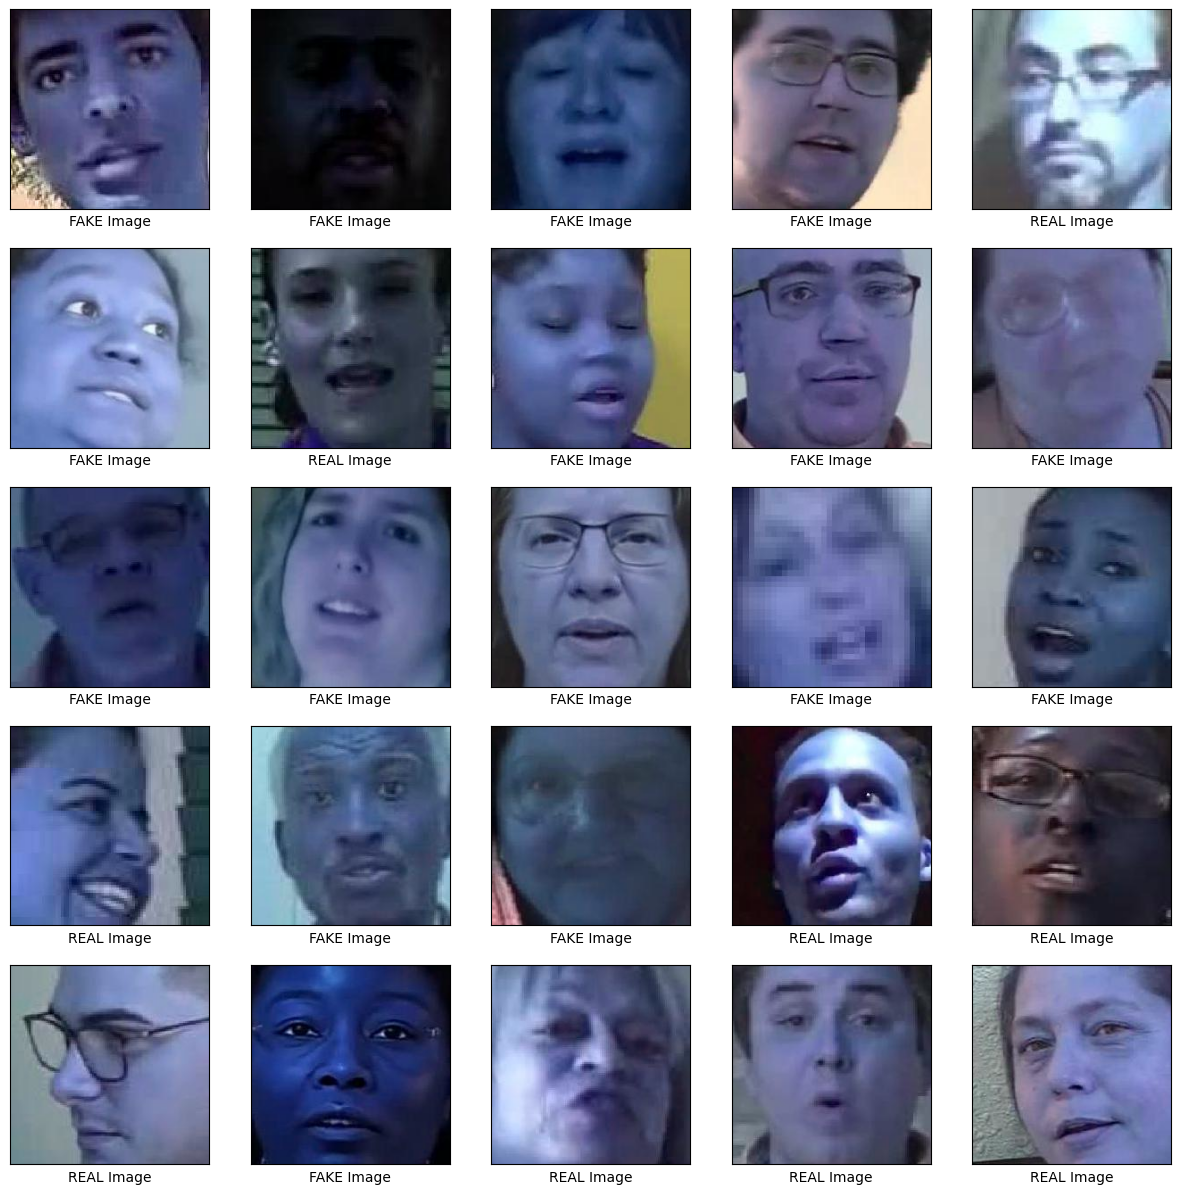

In [ ]:
# # 이미지 검토
# plt.figure(figsize=(15,15))
# for cur,i in enumerate(Train_set.index[25:50]):
#     plt.subplot(5,5,cur+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)

#     plt.imshow(cv2.imread('/content/drive/MyDrive/faces/'+Train_set.loc[i,'videoname']))

#     if(Train_set.loc[i,'label']=='FAKE'):
#         plt.xlabel('FAKE Image')
#     else:
#         plt.xlabel('REAL Image')

# plt.show()

In [ ]:
!pip install Pillow

In [ ]:
from PIL import Image
import os

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from __future__ import print_function
import argparse
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed


In [ ]:
def load_and_process_image(img_path):
    image = cv2.imread(img_path)
    if image is not None:
        image = cv2.resize(image, (224, 224))  # 이미지 크기를 조정
        image = image.astype(np.float32) / 255.0  # 데이터 타입을 float32로 변경
    return image

def retrieve_dataset(set_name):
    images, labels = [], []
    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_img = {executor.submit(load_and_process_image, '/content/drive/MyDrive/faces/' + img): img for img in set_name['videoname']}
        for future in as_completed(future_to_img):
            img_path = future_to_img[future]
            image = future.result()
            if image is not None:
                images.append(image)
                imclass = set_name.loc[set_name['videoname'] == img_path.split('/')[-1], 'label'].values[0]
                labels.append(1 if imclass == 'FAKE' else 0)
            else:
                print(f"Failed to load image {img_path}")

    return np.array(images), np.array(labels)

In [17]:
X_train,y_train=retrieve_dataset(Train_set)
X_val,y_val=retrieve_dataset(Val_set)
X_test,y_test=retrieve_dataset(Test_set)

In [18]:
# DataLoader 설정
class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.transpose((0, 3, 1, 2))).float()  # NHWC to NCHW and convert to float32
        self.y = torch.from_numpy(y).long()  # Convert labels to long

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
# 데이터셋 인스턴스 생성
train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
class BottleNeck(nn.Module):
    expansion_factor = 2
    def __init__(self, in_channels: int, group_width: int,cardinality, stride: int = 1,base_width : int=64):
        super(BottleNeck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, group_width, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1,groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(group_width, group_width * self.expansion_factor, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(group_width*self.expansion_factor)

        self.relu3 = nn.ReLU()
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != group_width * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, group_width*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(group_width*self.expansion_factor))

    def forward(self, x):
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x += self.residual(out)
        x = self.relu3(x)
        return x



In [21]:
class ResNext(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2,  cardinality: int =32, width : int=4):
        super(ResNext, self).__init__()
        self.in_channels = 64
        self.group_conv_width = cardinality * width
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=4, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2 = self._make_layer(block, cardinality, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block, cardinality, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block, cardinality, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block, cardinality, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(self.group_conv_width, num_classes)

        self._init_layer()

    def _make_layer(self, block, cardinality, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, self.group_conv_width, cardinality, stride))
            self.in_channels =  block.expansion_factor*self.group_conv_width
        self.group_conv_width *= block.expansion_factor
        return nn.Sequential(*layers)

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [26]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 모델을 훈련 모드로 설정
    total_loss = 0
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch + 1) % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"Training loss: {loss.item():>7f} at sample [{current:>5d}/{size:>5d}]")

    print(f"Average training loss: {total_loss / len(dataloader):>8f}")
def test(dataloader, model, loss_fn, stage='Validation', plot_results=False):
    model.eval()
    test_loss, correct = 0, 0
    y_true, y_probs, y_pred = [], [], []
    roc_auc = None  # 초기화
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            outputs = model(X)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            test_loss += loss_fn(outputs, y).item()
            correct += (predicted == y).type(torch.float).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            y_probs.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification for class "1"

    accuracy = correct / len(dataloader.dataset)
    print(f"{stage} Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss / len(dataloader):>8f} \n")

    if plot_results:
        # Calculate and plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {stage}')
        plt.legend(loc="lower right")
        plt.show()

        # Plot Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    return y_true, y_pred, roc_auc

def train_loop(model, epochs, train_loader, val_loader, test_loader):
    model = model.cuda()  # 모델을 GPU로 이동
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer)
        test(val_loader, model, loss_fn, stage='Validation')

    print("Final evaluation on test dataset:")
    y_true, y_pred, roc_auc = test(test_loader, model, loss_fn, stage='Test', plot_results=True)  # plot_results는 여기에서만 사용

    # Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [27]:
model = ResNext(BottleNeck, [3,4,23,3])

Epoch 1
-------------------------------
Training loss: 0.600950 at sample [ 3200/13440]
Training loss: 0.669535 at sample [ 6400/13440]
Training loss: 0.601318 at sample [ 9600/13440]
Training loss: 0.669624 at sample [12800/13440]
Average training loss: 0.673708
Validation Error: 
 Accuracy: 66.5%, Avg loss: 0.615500 

Epoch 2
-------------------------------
Training loss: 0.674882 at sample [ 3200/13440]
Training loss: 0.565182 at sample [ 6400/13440]
Training loss: 0.496594 at sample [ 9600/13440]
Training loss: 0.656245 at sample [12800/13440]
Average training loss: 0.626735
Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.618726 

Epoch 3
-------------------------------
Training loss: 0.678621 at sample [ 3200/13440]
Training loss: 0.580990 at sample [ 6400/13440]
Training loss: 0.469565 at sample [ 9600/13440]
Training loss: 0.715484 at sample [12800/13440]
Average training loss: 0.613212
Validation Error: 
 Accuracy: 67.1%, Avg loss: 0.603262 

Epoch 4
--------------------------

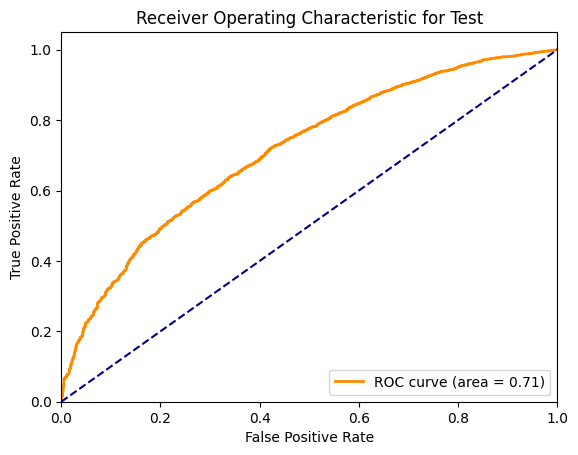

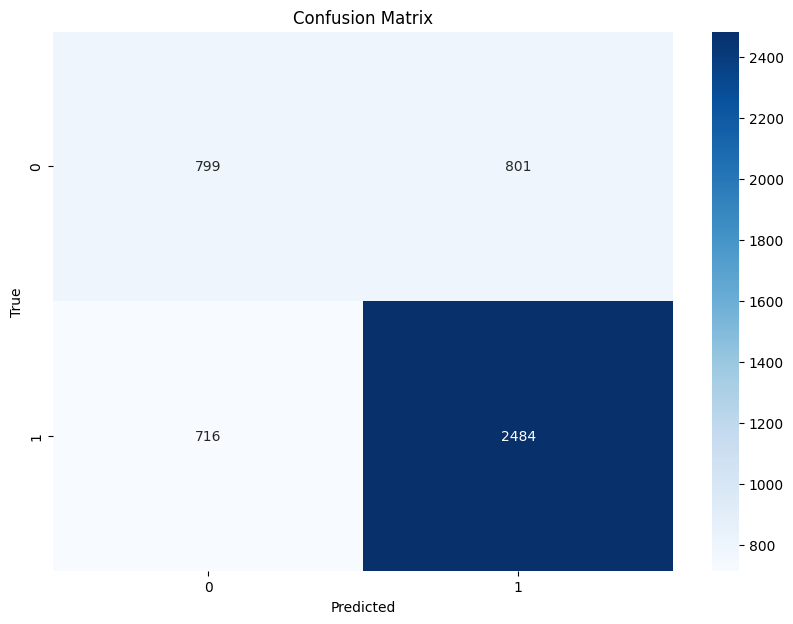

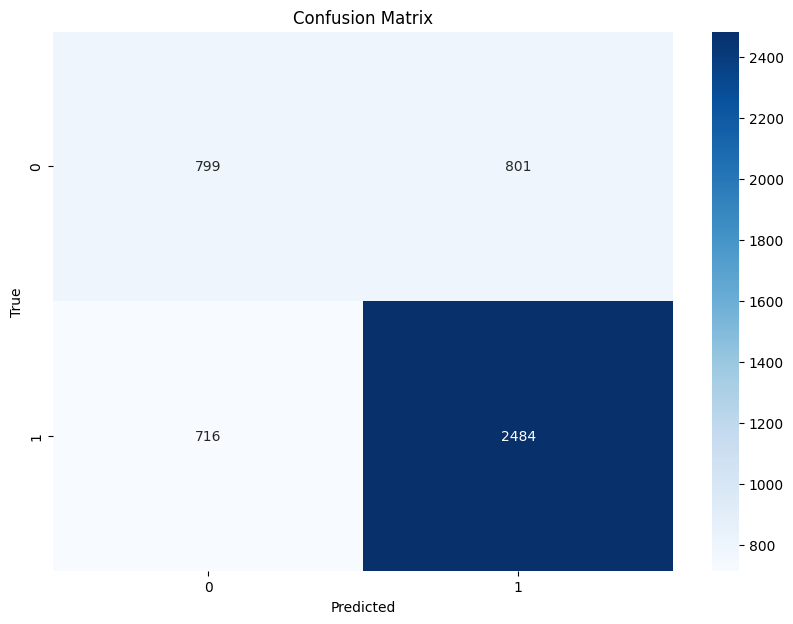

In [28]:
train_loop(model, 10, train_loader, val_loader, test_loader)